#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

In [89]:
try:
    df = pd.read_csv("taxi.csv", index_col = [0], parse_dates = [0])
except:
    df = pd.read_csv("/datasets/taxi.csv", index_col = [0], parse_dates = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [91]:
#проверим пропуски
df.isnull().sum()

num_orders    0
dtype: int64

In [92]:
#проверим упорядочены ли индексы
print(df.index.is_monotonic)

True


In [93]:
#проведем ресемплинг по каждому часу
hr = df.resample("1H").sum()
hr.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

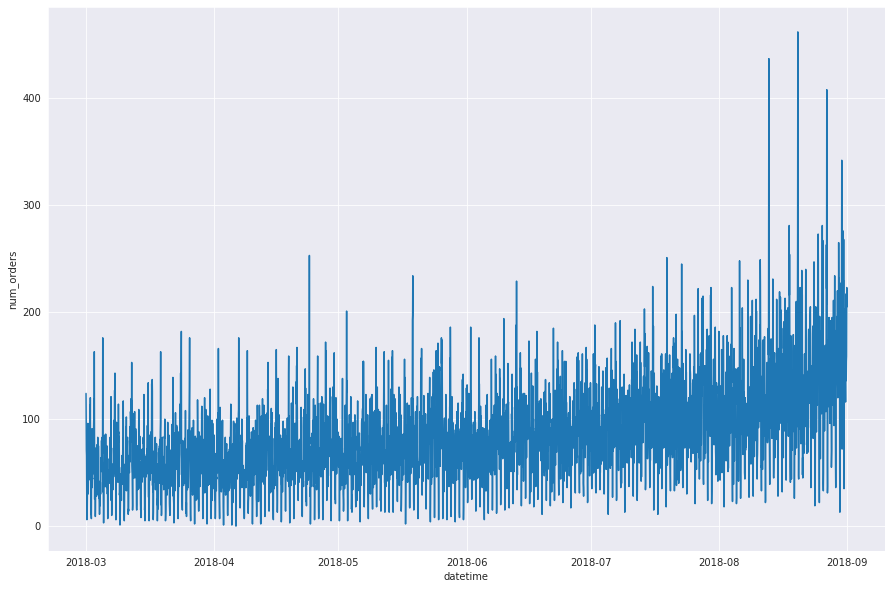

In [94]:
#посмотрим на наши заказы
plt.figure(figsize=(15,10))
sns.lineplot(x=hr.index, y=hr["num_orders"])

Text(0.5, 1.0, 'Скользящее среднее и скользящее стандартное отклонение')

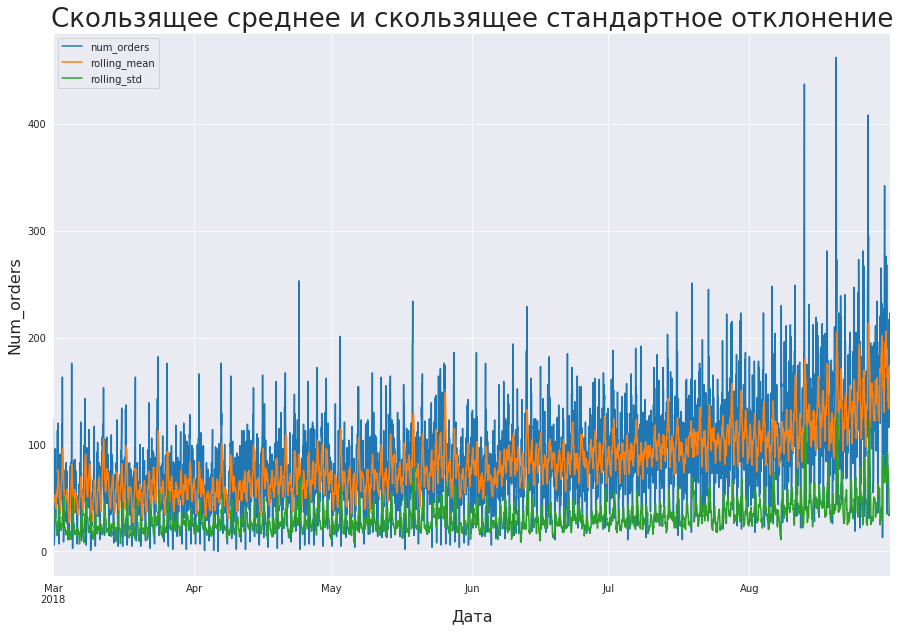

In [95]:
#скользящее среднее и скользящее стандартное отклонение
hr["rolling_mean"] = hr["num_orders"].rolling(10).mean()
hr["rolling_std"] = hr["num_orders"].rolling(10).std()
hr.plot(figsize=(15,10))
plt.xlabel("Дата", fontsize=16)
plt.ylabel("Num_orders", fontsize=16)
plt.title("Скользящее среднее и скользящее стандартное отклонение", fontsize=26)

In [96]:
hr = hr.dropna()

In [97]:
decomposed_hr = seasonal_decompose(hr)

<Figure size 1080x720 with 0 Axes>

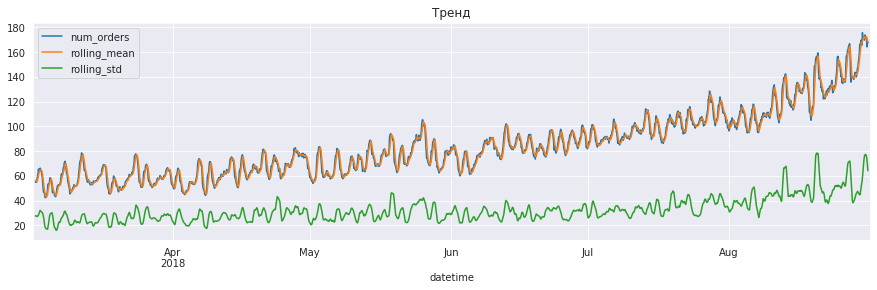

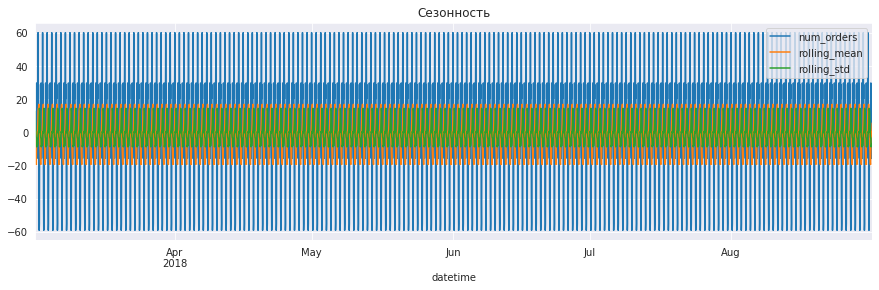

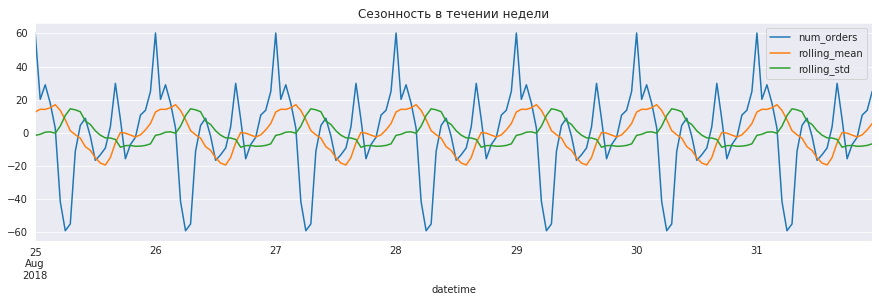

In [98]:
plt.figure(figsize=(15,10))
decomposed_hr.trend.plot(title='Тренд', figsize=(15,4))

decomposed_hr.seasonal.plot(title="Сезонность", figsize=(15,4))

decomposed_hr.seasonal.tail(24*7).plot(title="Сезонность в течении недели", figsize=(15,4))


**Вывод:** 
> На графике Тренд видно что количество заказов постепенно увеличивается.  
Сезонность остается в целом неизменной

## Обучение

In [99]:
df = df.resample("1H").sum()

In [100]:
#создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data["day_of_week"] = data.index.dayofweek
    data["hour"] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)
        
    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 6, 11)
df.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [101]:
df.describe()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4405.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.312723
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,29.206033
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.818182
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.818182
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,80.545455
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,100.454545
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,208.090909


In [102]:
#разделим таблицу на обучающюю и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(["num_orders"], axis=1)
y_train = train["num_orders"]

X_test = test.drop(["num_orders"], axis=1)
y_test = test["num_orders"]

In [103]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X_train.shape[0], X_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3963 объектов, 9 признаков
Размер тестовой выборки: 442 объектов, 9 признаков


In [113]:
# LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
pridictions_lr = model.predict(X_train)
print("RMSE обучающей выборки:", mean_squared_error(y_train, pridictions_lr)**0.5)

RMSE обучающей выборки: 31.185188112777904


In [106]:
model_lgb = lgb.LGBMRegressor()

In [107]:
param_search = {'max_depth' : [20, 50], 'n_estimators': [50, 100, 200],
               'learning_rate': [0.1, 0.25, 0.5]}
my_cv = TimeSeriesSplit(n_splits=6).split(X_train)
gsearch = RandomizedSearchCV(estimator=model_lgb, cv=my_cv,
                        param_distributions=param_search)
gsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd7fe651ad0>,
                   error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                         

In [115]:
gsearch.best_params_

{'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1}

**Вывод:**  
> Поработаем с моделью LightGBM 

## Тестирование

In [116]:
lgb_model = lgb.LGBMRegressor(n_estimators=50, max_depth=20, learning_rate=0.1)
lgb_model.fit(X_train, y_train)
predictions = lgb_model.predict(X_test)
print('RMSE на тестовой выборке:', mean_squared_error(y_test, predictions)**0.5)

RMSE на тестовой выборке: 45.76788559175611


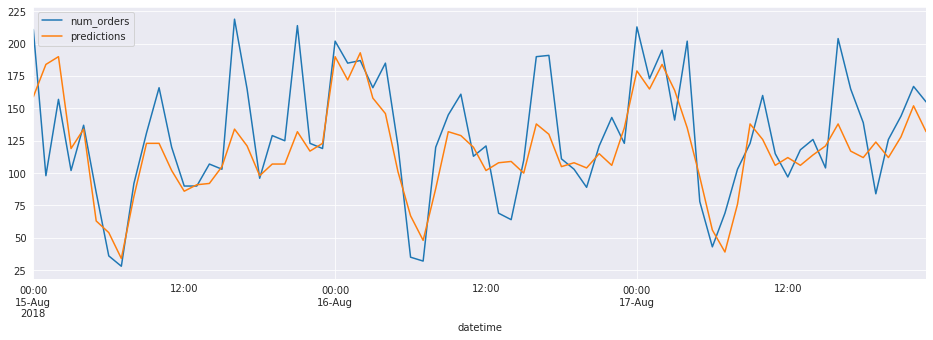

In [117]:
#вычитал на kaggle вот какую штуку для проверки временных рядом, интересно))) полезно бы ее включить в тренажер
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

**Вывод:**  
> Из графика видно что наша модель достаточно хорошо предсказывает данные

## Общий вывод:

Нам был дан ДатаФрейм, мы провели его ресемплинг, анализ, удалили пропущенные значения и получили признаки. Получили обучающую и тестовую выборки и провели обучение двух моделей, больше всего нам подошла модель LightGBM, на которой мы провели тестирование.  
На выходе результат RMSE На тестовой выборке равен 16, что соответствует нашим условиям выполнили задание